# Regressor de fluxo

A principal ideia deste regressor é:

* Encontrar os fluxos baseados nas features como populacao, distancia da ligacao, REGIC.

* Verificar quais features possuem mais influência no regressor

* Testar diferentes modelos

In [1]:
import pandas as pd

In [2]:
#Dados arranjos/mun
df_cidades = pd.read_csv("../data/integrado/arr_mun.csv")

#Dataframe com os rotulos
df_rodoviario = pd.read_csv("../data/calculado/arr_calculo_qtd_fluxo.csv")

#Dataframe com as features
#Dados das ligacoes rodoviarias e hidroviaria IBGE 2016
df_li_trans = pd.read_csv('../data/fluxo_transporte/lig_rodo_hidro.csv', sep=",")
df_li_trans = pd.DataFrame(df_li_trans[['CODMUNDV_A', 'CODMUNDV_B','VAR03','VAR04','VAR06']])
df_li_trans.rename(columns={"ID": "id", "CODMUNDV_A": "cod_mun_a", "CODMUNDV_B": "cod_mun_b",'VAR03':"custo_min",'VAR04':"tempo_min", "VAR06": "freq_saida"}, inplace=True)

#Dados do REGIC 2018
#Integrado
df_regic = pd.read_csv('../data/integrado/cidades_regic.csv')
#Bruto
df_regic_lig = pd.read_excel(open('../data/regic/REGIC2018_Ligacoes_entre_Cidades.xlsx', 'rb'), sheet_name='REGIC2018_Ligacoes_entre_Cidade', 
                               dtype = {'cod_ori': int, 'cod_dest': int})
df_regic_lig.rename(columns={"cod_ori":"cod_origem", "cod_dest":"cod_destino"}, inplace=True)                            

In [3]:
df_li_trans_2 = pd.DataFrame(df_li_trans)
df_li_trans_2.rename(columns={"cod_mun_a":"cod_mun_b", "cod_mun_b":"cod_mun_a"}, inplace=True)

df_lig = pd.concat([df_li_trans_2,df_li_trans])
df_lig.rename(columns={"cod_mun_a":"cod_origem", "cod_mun_b":"cod_destino"}, inplace=True)

In [4]:
df_regic = df_regic.merge(df_cidades[['cod_cidade','populacao_2021']], 
                how='inner', 
                left_on=["cod_mun"], 
                right_on=["cod_cidade"])

In [5]:
df_regic_dest = pd.DataFrame(df_regic.add_suffix('_dest'))
df_regic_ori = pd.DataFrame(df_regic.add_suffix('_ori'))

df_regic_merge = df_lig.merge(df_regic_dest, 
                how='inner', 
                left_on=["cod_destino"], 
                right_on=["cod_mun_dest"])

df_regic_merge = df_regic_merge.merge(df_regic_ori, 
                how='inner', 
                left_on=["cod_origem"], 
                right_on=["cod_mun_ori"])


In [6]:
df_features_temp =  df_rodoviario.merge(df_regic_merge, 
                how='inner', 
                left_on=["cod_destino", "cod_origem"], 
                right_on=["cod_destino", "cod_origem"])

In [7]:
df_label = df_features_temp[["passageiros_rodov"]]
df_features = df_features_temp[[
        'custo_min', 'tempo_min', 'freq_saida',
        'pib_dest', 'PIB_agro_dest', 'PIB_ind_dest',
        'PIB_serv_dest', 'PIB_pub_dest', 'hierarquia_dest',
        'CGT_dest', 'CI_dest', 'CGP_dest',
        'indice_atracao_dest', 'ia_vestuario_dest', 'ia_moveis_dest',
        'ia_saude_bm_dest', 'ia_saude_a_dest', 'ia_ensino_sup_dest',
        'ia_cultura_dest', 'ia_esporte_dest', 'ia_aeroporto_dest',
        'ia_jornal_dest', 'ia_transporte_dest', 'num_leitos_dest',
        'pib_ori', 'PIB_agro_ori', 'PIB_ind_ori', 'PIB_serv_ori',
        'PIB_pub_ori', 'hierarquia_ori', 'CGT_ori',
        'CI_ori', 'CGP_ori', 'indice_atracao_ori', 'ia_vestuario_ori',
        'ia_moveis_ori', 'ia_saude_bm_ori', 'ia_saude_a_ori',
        'ia_ensino_sup_ori', 'ia_cultura_ori', 'ia_esporte_ori',
        'ia_aeroporto_ori', 'ia_jornal_ori', 'ia_transporte_ori','num_leitos_ori',
        'populacao_2021_dest', 'populacao_2021_ori'
       ]]

In [8]:
#Utilizando ligacoes do regic (vai no sentido de piramide)
# df_merge = df_rodoviario.merge(df_lig, 
#                 how='inner', 
#                 left_on=["cod_destino", "cod_origem"], 
#                 right_on=["cod_destino", "cod_origem"])

# df_features_1 = df_merge[["custo_min", "tempo_min", "freq_saida"]]
# df_label_1 = df_merge[["passageiros_rodov"]]

# df_merge = df_merge.merge(df_regic_lig, 
#                 how='inner', 
#                 left_on=["cod_destino", "cod_origem"], 
#                 right_on=["cod_destino", "cod_origem"])

# df_features_2 = df_merge[["custo_min", "tempo_min", "freq_saida", "dist_km","nivel_ori","nivel_dest",
# "quest", "quest_1","quest_2","quest_3","quest_4","quest_5","quest_6","quest_7","quest_8","quest_9","quest_10"]]
# df_label_2 = df_merge[["passageiros_rodov"]]

In [9]:
#Transformando variáveis categóricas em numéricas
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

hier = df_features["hierarquia_ori"].unique()
hier.sort()
le.fit(hier)
df_features["hierarquia_ori"] = le.transform(df_features["hierarquia_ori"])
df_features["hierarquia_dest"] = le.transform(df_features["hierarquia_dest"])


/var/folders/rv/x_8qm7392xv0jjj7dh82d9nm0000gn/T/ipykernel_88938/2438578283.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features["hierarquia_ori"] = le.transform(df_features["hierarquia_ori"])
/var/folders/rv/x_8qm7392xv0jjj7dh82d9nm0000gn/T/ipykernel_88938/2438578283.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features["hierarquia_dest"] = le.transform(df_features["hierarquia_dest"])


In [10]:
#Preenchendo dados faltantes
df_features = df_features.fillna(0)

In [11]:
df_features.shape

(22614, 47)

In [12]:
#Tranformando dataset to array
X = df_features.to_numpy()
y = df_label.values.ravel()

In [13]:
#Perform Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_sc = sc.fit_transform(X)

Visualizando os dados

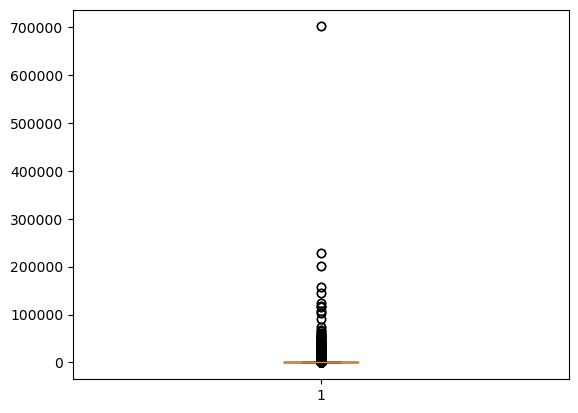

In [56]:
import matplotlib.pyplot as plt
plt.boxplot(y)
plt.show()

## Classificadores


In [12]:
from time import time

from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

In [15]:
#Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_sc, y,random_state=1, test_size=0.1)

In [432]:
regressors = [
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    ExtraTreesRegressor(),
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    LinearRegression(),
    Lasso(),
    Ridge(),
    SVR()
]

In [433]:
head = 10
for model in regressors:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean absolute error:", mean_absolute_error(y_test, y_pred))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print()

KNeighborsRegressor()
	Training time: 0.006s
	Prediction time: 0.313s
	Explained variance: 0.4415404579776999
	Mean absolute error: 754.4516357206013
	R2 score: 0.4412773890695978

GradientBoostingRegressor()
	Training time: 15.197s
	Prediction time: 0.005s
	Explained variance: 0.392316037220087
	Mean absolute error: 900.590035845245
	R2 score: 0.391854312859809

ExtraTreesRegressor()
	Training time: 20.670s
	Prediction time: 0.090s
	Explained variance: 0.7196131197068768
	Mean absolute error: 146.69698496905391
	R2 score: 0.7191530168688942

RandomForestRegressor()
	Training time: 58.414s
	Prediction time: 0.096s
	Explained variance: 0.6530003440326217
	Mean absolute error: 422.9564500442087
	R2 score: 0.6524655737729351

DecisionTreeRegressor()
	Training time: 0.861s
	Prediction time: 0.001s
	Explained variance: 0.9594203251835778
	Mean absolute error: 104.33598585322723
	R2 score: 0.9593477649669431

LinearRegression()
	Training time: 0.079s
	Prediction time: 0.000s
	Explained varia

/opt/miniconda3/envs/alerta_epidemia/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.466e+10, tolerance: 1.598e+08
  model = cd_fast.enet_coordinate_descent(


Lasso()
	Training time: 1.895s
	Prediction time: 0.000s
	Explained variance: 0.04997261242415507
	Mean absolute error: 1700.295343192962
	R2 score: 0.049687653630098194

Ridge()
	Training time: 0.014s
	Prediction time: 0.000s
	Explained variance: 0.0465368371049556
	Mean absolute error: 1715.6557142948934
	R2 score: 0.046256509214219865

SVR()
	Training time: 58.534s
	Prediction time: 11.215s
	Explained variance: 0.0146867648397635
	Mean absolute error: 857.8168686895025
	R2 score: -0.015467497387374518



### Gradient Regressor

In [142]:
param_test1 = {'n_estimators':range(100,2000,100)}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.3, min_samples_split=150,min_samples_leaf=10,max_depth=6,max_features='sqrt',subsample=0.8,random_state=10), param_grid = param_test1, scoring='r2',n_jobs=-1, cv=5,verbose=3)
gsearch1.fit(X_train, y_train)


Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV 3/5] END ..................n_estimators=100;, score=0.706 total time=   5.7s
[CV 2/5] END ..................n_estimators=100;, score=0.878 total time=   5.7s
[CV 4/5] END ..................n_estimators=100;, score=0.683 total time=   5.8s
[CV 1/5] END ..................n_estimators=100;, score=0.894 total time=   5.8s
[CV 5/5] END ..................n_estimators=100;, score=0.533 total time=   5.3s
[CV 3/5] END ..................n_estimators=200;, score=0.789 total time=  10.3s
[CV 1/5] END ..................n_estimators=200;, score=0.955 total time=  10.5s
[CV 2/5] END ..................n_estimators=200;, score=0.929 total time=  10.4s
[CV 4/5] END ..................n_estimators=200;, score=0.728 total time=  10.9s
[CV 5/5] END ..................n_estimators=200;, score=0.620 total time=  11.5s
[CV 2/5] END ..................n_estimators=300;, score=0.939 total time=  16.7s
[CV 1/5] END ..................n_estimators=300;

GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(learning_rate=0.3, max_depth=6,
                                                 max_features='sqrt',
                                                 min_samples_leaf=10,
                                                 min_samples_split=150,
                                                 random_state=10,
                                                 subsample=0.8),
             n_jobs=-1, param_grid={'n_estimators': range(100, 2000, 100)},
             scoring='r2', verbose=3)

In [143]:
resultsRF = pd.DataFrame(gsearch1.cv_results_)
resultsRF.sort_values(by='rank_test_score', inplace=True)
resultsRF.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
18,87.543564,13.938332,0.273790,0.053316,1900,{'n_estimators': 1900},0.976009,0.949067,0.894049,0.768475,0.725421,0.862604,0.099000,1
17,83.192796,0.866931,0.330453,0.019484,1800,{'n_estimators': 1800},0.976011,0.949050,0.893744,0.768305,0.725412,0.862504,0.099013,2
16,80.310978,0.580750,0.297926,0.009537,1700,{'n_estimators': 1700},0.975995,0.948994,0.893473,0.767972,0.724786,0.862244,0.099219,3
15,79.575296,2.004323,0.276269,0.002200,1600,{'n_estimators': 1600},0.975949,0.948934,0.893226,0.767800,0.724831,0.862148,0.099202,4
14,70.912271,2.021850,0.248852,0.004108,1500,{'n_estimators': 1500},0.975904,0.948851,0.892872,0.767637,0.724262,0.861905,0.099344,5


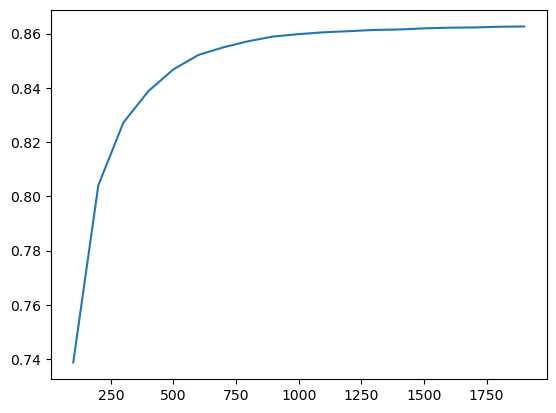

In [144]:
plt.plot(resultsRF['param_n_estimators'],resultsRF['mean_test_score'], linestyle='solid')

In [172]:
# param_test2 = {'max_depth':range(5,16,2), 'min_samples_split': range(200,601,100)}
param_test2 = {'max_depth':[5,11], 'min_samples_split': range(90,251,10)}
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(n_estimators = 1200, learning_rate=0.3, min_samples_leaf=10,max_features='sqrt',subsample=0.8,random_state=10), param_grid = param_test2, scoring='r2',n_jobs=-1, cv=5,verbose=3)
gsearch2.fit(X_train, y_train)

Fitting 5 folds for each of 34 candidates, totalling 170 fits
[CV 2/5] END .max_depth=5, min_samples_split=90;, score=0.958 total time= 1.0min
[CV 1/5] END .max_depth=5, min_samples_split=90;, score=0.979 total time= 1.0min
[CV 3/5] END .max_depth=5, min_samples_split=90;, score=0.883 total time= 1.0min
[CV 4/5] END .max_depth=5, min_samples_split=90;, score=0.753 total time= 1.0min
[CV 5/5] END .max_depth=5, min_samples_split=90;, score=0.838 total time=  52.9s
[CV 1/5] END max_depth=5, min_samples_split=100;, score=0.979 total time=  53.4s
[CV 2/5] END max_depth=5, min_samples_split=100;, score=0.947 total time=  53.2s
[CV 3/5] END max_depth=5, min_samples_split=100;, score=0.900 total time=  53.0s
[CV 5/5] END max_depth=5, min_samples_split=100;, score=0.680 total time=  52.6s
[CV 4/5] END max_depth=5, min_samples_split=100;, score=0.851 total time=  53.5s
[CV 2/5] END max_depth=5, min_samples_split=110;, score=0.947 total time=  52.9s
[CV 1/5] END max_depth=5, min_samples_split=110

GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(learning_rate=0.3,
                                                 max_features='sqrt',
                                                 min_samples_leaf=10,
                                                 n_estimators=1200,
                                                 random_state=10,
                                                 subsample=0.8),
             n_jobs=-1,
             param_grid={'max_depth': [5, 11],
                         'min_samples_split': range(90, 251, 10)},
             scoring='r2', verbose=3)

In [175]:
resultsRF = pd.DataFrame(gsearch2.cv_results_)
resultsRFSorted = resultsRF.sort_values(by='rank_test_score')
resultsRFSorted.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,51.111657,0.738826,0.157866,0.009093,5,120,"{'max_depth': 5, 'min_samples_split': 120}",0.970840,0.943342,0.877183,0.907935,0.834095,0.906679,0.048168,1
18,92.401500,0.571745,0.397366,0.026092,11,100,"{'max_depth': 11, 'min_samples_split': 100}",0.975931,0.946130,0.897996,0.824899,0.887570,0.906505,0.051924,2
9,51.153685,0.613390,0.186147,0.017064,5,180,"{'max_depth': 5, 'min_samples_split': 180}",0.975543,0.951601,0.855748,0.827678,0.905114,0.903137,0.055741,3
6,51.624215,0.183304,0.179210,0.010843,5,150,"{'max_depth': 5, 'min_samples_split': 150}",0.973933,0.942859,0.844435,0.921597,0.811832,0.898931,0.061032,4
25,93.186033,0.561039,0.421406,0.119275,11,170,"{'max_depth': 11, 'min_samples_split': 170}",0.975297,0.955587,0.877409,0.831333,0.851810,0.898287,0.057084,5


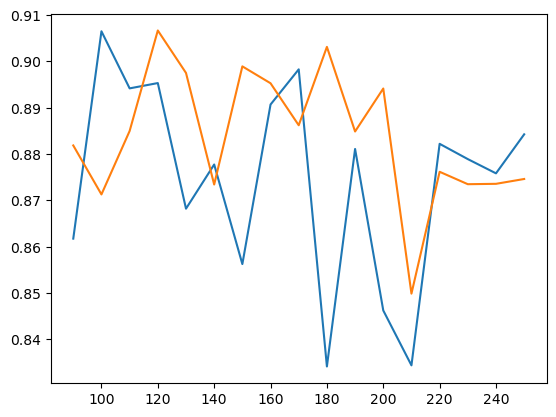

In [174]:
resultsRF11 = resultsRF[resultsRF.param_max_depth == 11]
resultsRF5 = resultsRF[resultsRF.param_max_depth == 5]
# resultsRF15 = resultsRF[resultsRF.param_max_depth == 15]

plt.plot(resultsRF11['param_min_samples_split'],resultsRF11['mean_test_score'], linestyle='solid')
plt.plot(resultsRF5['param_min_samples_split'],resultsRF5['mean_test_score'], linestyle='solid')
# plt.plot(resultsRF15['param_min_samples_split'],resultsRF15['mean_test_score'], linestyle='solid')

In [177]:
param_test3 = {'min_samples_leaf':range(2,22,3)}
gsearch3 = GridSearchCV(estimator = GradientBoostingRegressor(n_estimators = 1200, min_samples_split = 120, max_depth = 5, learning_rate=0.3,max_features='sqrt',subsample=0.8,random_state=10), param_grid = param_test3, scoring='r2',n_jobs=-1, cv=5,verbose=3)
gsearch3.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 4/5] END ................min_samples_leaf=2;, score=0.840 total time= 1.4min
[CV 2/5] END ................min_samples_leaf=2;, score=0.955 total time= 1.4min
[CV 3/5] END ................min_samples_leaf=2;, score=0.901 total time= 1.4min
[CV 1/5] END ................min_samples_leaf=2;, score=0.976 total time= 1.4min
[CV 2/5] END ................min_samples_leaf=5;, score=0.952 total time=  56.1s
[CV 1/5] END ................min_samples_leaf=5;, score=0.966 total time=  56.2s
[CV 3/5] END ................min_samples_leaf=5;, score=0.878 total time=  55.9s
[CV 5/5] END ................min_samples_leaf=2;, score=0.881 total time=  56.7s
[CV 4/5] END ................min_samples_leaf=5;, score=0.825 total time=  49.9s
[CV 2/5] END ................min_samples_leaf=8;, score=0.949 total time=  49.6s
[CV 1/5] END ................min_samples_leaf=8;, score=0.972 total time=  49.8s
[CV 5/5] END ................min_samples_leaf=5;,

GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(learning_rate=0.3, max_depth=5,
                                                 max_features='sqrt',
                                                 min_samples_split=120,
                                                 n_estimators=1200,
                                                 random_state=10,
                                                 subsample=0.8),
             n_jobs=-1, param_grid={'min_samples_leaf': range(2, 22, 3)},
             scoring='r2', verbose=3)

In [178]:
resultsRF = pd.DataFrame(gsearch3.cv_results_)
resultsRFSorted = resultsRF.sort_values(by='rank_test_score')
resultsRFSorted

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,78.266805,10.917440,0.276080,0.028411,2,{'min_samples_leaf': 2},0.975806,0.955133,0.901251,0.840404,0.881436,0.910806,0.049194,1
1,53.423303,2.987192,0.191543,0.010877,5,{'min_samples_leaf': 5},0.966365,0.951908,0.877504,0.825092,0.876251,0.899424,0.052495,2
3,50.813691,0.176042,0.210233,0.044215,11,{'min_samples_leaf': 11},0.977596,0.943157,0.855142,0.875656,0.790777,0.888466,0.065959,3
4,52.772209,0.849107,0.231048,0.034067,14,{'min_samples_leaf': 14},0.969468,0.949051,0.854854,0.865369,0.795665,0.886881,0.064023,4
2,50.185026,0.593472,0.184518,0.004950,8,{'min_samples_leaf': 8},0.971934,0.948786,0.860611,0.808706,0.838985,0.885804,0.063491,5
5,53.340750,1.669533,0.216446,0.035020,17,{'min_samples_leaf': 17},0.972471,0.940699,0.782292,0.879959,0.822440,0.879572,0.070844,6
6,44.438704,5.526559,0.143997,0.030173,20,{'min_samples_leaf': 20},0.973692,0.957613,0.782243,0.860861,0.774565,0.869795,0.084048,7


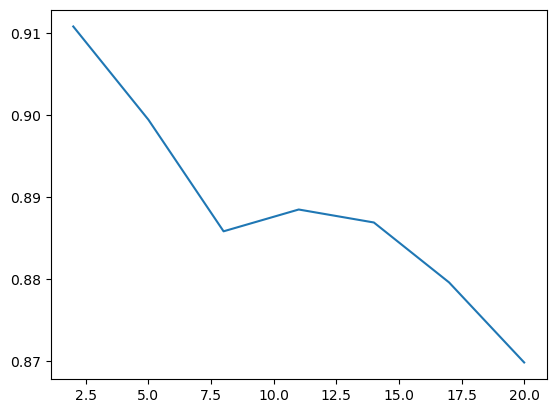

In [181]:
plt.plot(resultsRF['param_min_samples_leaf'],resultsRF['mean_test_score'], linestyle='solid')

In [182]:
param_test4 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch4 = GridSearchCV(estimator = GradientBoostingRegressor(n_estimators = 1200, min_samples_split = 120, max_depth = 5, learning_rate=0.3,max_features='sqrt',random_state=10), param_grid = param_test4, scoring='r2',n_jobs=-1, cv=5,verbose=3)
gsearch4.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 3/5] END .....................subsample=0.6;, score=0.870 total time= 1.2min
[CV 4/5] END .....................subsample=0.6;, score=0.805 total time= 1.2min
[CV 2/5] END .....................subsample=0.6;, score=0.944 total time= 1.2min
[CV 1/5] END .....................subsample=0.6;, score=0.975 total time= 1.2min
[CV 5/5] END .....................subsample=0.6;, score=0.886 total time=  42.8s
[CV 1/5] END .....................subsample=0.7;, score=0.974 total time=  48.7s
[CV 2/5] END .....................subsample=0.7;, score=0.940 total time=  48.8s
[CV 3/5] END .....................subsample=0.7;, score=0.907 total time=  48.8s
[CV 4/5] END .....................subsample=0.7;, score=0.804 total time=  48.4s
[CV 5/5] END .....................subsample=0.7;, score=0.831 total time=  48.8s
[CV 1/5] END ....................subsample=0.75;, score=0.970 total time=  52.0s
[CV 2/5] END ....................subsample=0.75;,

GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(learning_rate=0.3, max_depth=5,
                                                 max_features='sqrt',
                                                 min_samples_split=120,
                                                 n_estimators=1200,
                                                 random_state=10),
             n_jobs=-1,
             param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]},
             scoring='r2', verbose=3)

In [183]:
resultsRF = pd.DataFrame(gsearch4.cv_results_)
resultsRFSorted = resultsRF.sort_values(by='rank_test_score')
resultsRFSorted

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,54.286579,0.677125,0.186047,0.006062,0.85,{'subsample': 0.85},0.971162,0.956310,0.912086,0.783044,0.896233,0.903767,0.066337,1
5,48.689692,10.555308,0.163818,0.045772,0.9,{'subsample': 0.9},0.972975,0.948370,0.909198,0.850024,0.832501,0.902614,0.054349,2
3,51.619177,0.628859,0.187521,0.006496,0.8,{'subsample': 0.8},0.972337,0.954444,0.899637,0.792983,0.872705,0.898421,0.063847,3
0,63.852719,10.616000,0.240763,0.068368,0.6,{'subsample': 0.6},0.975243,0.943877,0.870460,0.804613,0.885960,0.896031,0.059458,4
1,48.492884,0.133379,0.230508,0.048585,0.7,{'subsample': 0.7},0.973623,0.940300,0.906789,0.803693,0.831275,0.891136,0.064336,5
2,50.959152,0.912458,0.202310,0.014693,0.75,{'subsample': 0.75},0.970351,0.957165,0.898249,0.785940,0.834657,0.889272,0.070603,6


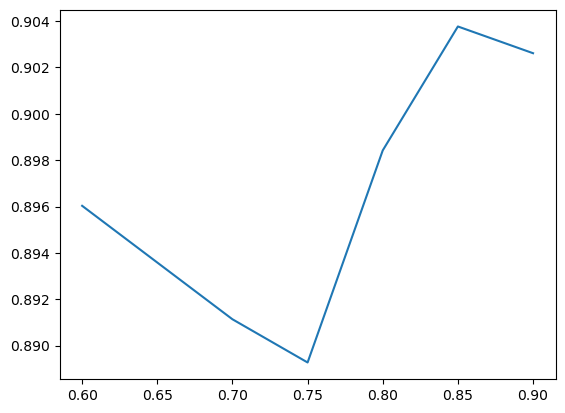

In [184]:
plt.plot(resultsRF['param_subsample'],resultsRF['mean_test_score'], linestyle='solid')

In [185]:
param_test5 = {"max_features":['sqrt', 15]}
gsearch5 = GridSearchCV(estimator = GradientBoostingRegressor(n_estimators = 1200, min_samples_split = 120, max_depth = 5, learning_rate=0.3,random_state=10), param_grid = param_test5, scoring='r2',n_jobs=-1, cv=5,verbose=3)
gsearch5.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 2/5] END .................max_features=sqrt;, score=0.943 total time= 1.5min
[CV 1/5] END .................max_features=sqrt;, score=0.977 total time= 1.5min
[CV 4/5] END .................max_features=sqrt;, score=0.765 total time= 1.4min
[CV 3/5] END .................max_features=sqrt;, score=0.907 total time= 1.4min
[CV 5/5] END .................max_features=sqrt;, score=0.821 total time= 1.0min
[CV 1/5] END ...................max_features=15;, score=0.978 total time= 2.3min
[CV 2/5] END ...................max_features=15;, score=0.945 total time= 2.3min
[CV 3/5] END ...................max_features=15;, score=0.926 total time= 2.3min
[CV 4/5] END ...................max_features=15;, score=0.794 total time= 1.9min
[CV 5/5] END ...................max_features=15;, score=0.869 total time= 1.3min


GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(learning_rate=0.3, max_depth=5,
                                                 min_samples_split=120,
                                                 n_estimators=1200,
                                                 random_state=10),
             n_jobs=-1, param_grid={'max_features': ['sqrt', 15]}, scoring='r2',
             verbose=3)

In [186]:
resultsRF = pd.DataFrame(gsearch5.cv_results_)
resultsRFSorted = resultsRF.sort_values(by='rank_test_score')
resultsRFSorted

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,120.097016,23.214200,0.144656,0.030537,15,{'max_features': 15},0.977506,0.945428,0.925595,0.794030,0.868975,0.902307,0.064640,1
0,80.943365,10.596979,0.203117,0.033285,sqrt,{'max_features': 'sqrt'},0.976892,0.943189,0.907176,0.764791,0.821440,0.882697,0.078467,2


In [188]:
param_test6 = {"learning_rate":[.15, .3], "n_estimators" : [1200, 2400]}
gsearch6 = GridSearchCV(estimator = GradientBoostingRegressor(n_estimators = 1200, min_samples_split = 120, max_depth = 5,max_features = 15,random_state=10), param_grid = param_test6, scoring='r2',n_jobs=-1, cv=5,verbose=3)
gsearch6.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 4/5] END learning_rate=0.15, n_estimators=1200;, score=0.783 total time= 2.3min
[CV 2/5] END learning_rate=0.15, n_estimators=1200;, score=0.945 total time= 2.3min
[CV 1/5] END learning_rate=0.15, n_estimators=1200;, score=0.977 total time= 2.4min
[CV 3/5] END learning_rate=0.15, n_estimators=1200;, score=0.917 total time= 2.4min
[CV 5/5] END learning_rate=0.15, n_estimators=1200;, score=0.880 total time= 2.3min
[CV 3/5] END learning_rate=0.15, n_estimators=2400;, score=0.926 total time= 4.7min
[CV 1/5] END learning_rate=0.15, n_estimators=2400;, score=0.978 total time= 4.7min
[CV 2/5] END learning_rate=0.15, n_estimators=2400;, score=0.945 total time= 4.7min
[CV 1/5] END learning_rate=0.3, n_estimators=1200;, score=0.978 total time= 2.3min
[CV 4/5] END learning_rate=0.15, n_estimators=2400;, score=0.784 total time= 4.7min
[CV 2/5] END learning_rate=0.3, n_estimators=1200;, score=0.945 total time= 2.3min
[CV 4/5] END learn

GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(max_depth=5, max_features=15,
                                                 min_samples_split=120,
                                                 n_estimators=1200,
                                                 random_state=10),
             n_jobs=-1,
             param_grid={'learning_rate': [0.15, 0.3],
                         'n_estimators': [1200, 2400]},
             scoring='r2', verbose=3)

In [189]:
resultsRF = pd.DataFrame(gsearch6.cv_results_)
resultsRFSorted = resultsRF.sort_values(by='rank_test_score')
resultsRFSorted

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,282.546424,1.791920,0.394441,0.043081,0.15,2400,"{'learning_rate': 0.15, 'n_estimators': 2400}",0.978360,0.945493,0.926328,0.783881,0.885919,0.903996,0.067090,1
3,249.391954,55.454996,0.302334,0.062946,0.3,2400,"{'learning_rate': 0.3, 'n_estimators': 2400}",0.977833,0.945390,0.927425,0.794289,0.869846,0.902957,0.064669,2
2,138.932309,0.558109,0.192284,0.011142,0.3,1200,"{'learning_rate': 0.3, 'n_estimators': 1200}",0.977506,0.945428,0.925595,0.794030,0.868975,0.902307,0.064640,3
0,140.784423,1.254595,0.185868,0.017446,0.15,1200,"{'learning_rate': 0.15, 'n_estimators': 1200}",0.976868,0.944738,0.917444,0.783075,0.880082,0.900441,0.066756,4


In [ ]:
GBR = GradientBoostingRegressor(n_estimators = 1200, min_samples_split = 120, max_depth = 5, learning_rate=0.3,subsample = .85,max_features=15,random_state=10)
GBR.fit(X_train, y_train)

In [207]:
y_train_pred = GBR.predict(X_train)
print(r2_score(y_train, y_train_pred))
y_test_pred = GBR.predict(X_test)
print(r2_score(y_test, y_test_pred))

0.999704084170247
0.951328165294895


In [201]:
res = pd.DataFrame()
res["real"] = y_test
res["pred"] = y_pred
res.head(50)

,real,pred
0,60.0,54.777382
1,11.0,-94.066583
2,33.0,20.102441
3,129.0,142.406818
4,459.0,532.728154
5,5.0,-134.254676
6,523.0,337.738697
7,75.0,-106.813562
8,62.0,66.523934
9,671.0,62.881334


In [194]:
GBR.feature_importances_[sorted_idx]

array([1.33979178e-04, 6.46288793e-04, 7.36058147e-04, 8.59591502e-04,
       9.44463540e-04, 1.06290605e-03, 1.09607873e-03, 1.13421333e-03,
       1.14003103e-03, 1.30415437e-03, 1.38651997e-03, 1.66616047e-03,
       1.84152414e-03, 1.84534187e-03, 2.27725453e-03, 2.38728212e-03,
       2.40073280e-03, 2.57026461e-03, 2.75660893e-03, 3.23459904e-03,
       3.51016088e-03, 3.67697906e-03, 3.85534995e-03, 4.74032768e-03,
       4.91915452e-03, 5.54494462e-03, 5.86104635e-03, 6.14304041e-03,
       6.20299750e-03, 6.92502464e-03, 7.30613555e-03, 7.31788738e-03,
       7.79053193e-03, 8.29407607e-03, 8.41098367e-03, 1.00327990e-02,
       1.07800425e-02, 1.16090052e-02, 1.32217182e-02, 1.41881886e-02,
       1.61601811e-02, 1.86160517e-02, 2.73688312e-02, 2.82225150e-02,
       4.52965548e-02, 9.83330713e-02, 5.84248348e-01])

Text(0.5, 0, 'Random Forest Feature Importance')

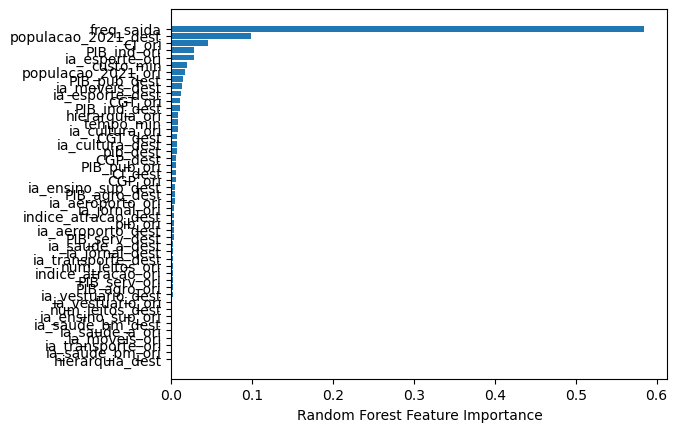

In [193]:
from matplotlib import pyplot as plt
sorted_idx = GBR.feature_importances_.argsort()
plt.barh(df_features.columns[sorted_idx], GBR.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [195]:
df_features.columns[sorted_idx]

Index(['hierarquia_dest', 'ia_saude_bm_ori', 'ia_transporte_ori',
       'ia_moveis_ori', 'ia_saude_a_ori', 'ia_saude_bm_dest',
       'ia_ensino_sup_ori', 'num_leitos_dest', 'ia_vestuario_ori',
       'ia_vestuario_dest', 'PIB_agro_ori', 'PIB_serv_ori',
       'indice_atracao_ori', 'num_leitos_ori', 'ia_transporte_dest',
       'ia_jornal_dest', 'ia_saude_a_dest', 'PIB_serv_dest',
       'ia_aeroporto_dest', 'pib_ori', 'indice_atracao_dest', 'ia_jornal_ori',
       'ia_aeroporto_ori', 'PIB_agro_dest', 'ia_ensino_sup_dest', 'CGP_ori',
       'CI_dest', 'PIB_pub_ori', 'CGP_dest', 'pib_dest', 'ia_cultura_dest',
       'CGT_dest', 'ia_cultura_ori', 'tempo_min', 'hierarquia_ori',
       'PIB_ind_dest', 'CGT_ori', 'ia_esporte_dest', 'ia_moveis_dest',
       'PIB_pub_dest', 'populacao_2021_ori', 'custo_min', 'ia_esporte_ori',
       'PIB_ind_ori', 'CI_ori', 'populacao_2021_dest', 'freq_saida'],
      dtype='object')

### RandomForest Regressor

In [75]:
param_test1 = {'n_estimators':range(100,300,10)}
gsearch1RF = GridSearchCV(estimator = RandomForestRegressor(min_samples_split=150,min_samples_leaf=10,max_depth=7,max_features=15,random_state=10), param_grid = param_test1, scoring='r2',n_jobs=-1, cv=5,verbose=3)
gsearch1RF.fit(X_train, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 3/5] END ..................n_estimators=100;, score=0.406 total time=  16.0s
[CV 1/5] END ..................n_estimators=100;, score=0.244 total time=  16.0s
[CV 2/5] END ..................n_estimators=100;, score=0.243 total time=  16.0s
[CV 4/5] END ..................n_estimators=100;, score=0.403 total time=  15.3s
[CV 5/5] END ..................n_estimators=100;, score=0.283 total time=  10.3s
[CV 2/5] END ..................n_estimators=110;, score=0.242 total time=  11.3s
[CV 1/5] END ..................n_estimators=110;, score=0.246 total time=  11.4s
[CV 3/5] END ..................n_estimators=110;, score=0.408 total time=  11.4s
[CV 4/5] END ..................n_estimators=110;, score=0.404 total time=  11.2s
[CV 5/5] END ..................n_estimators=110;, score=0.288 total time=  11.2s
[CV 2/5] END ..................n_estimators=120;, score=0.241 total time=  12.1s
[CV 1/5] END ..................n_estimators=120

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_depth=7, max_features=15,
                                             min_samples_leaf=10,
                                             min_samples_split=150,
                                             random_state=10),
             n_jobs=-1, param_grid={'n_estimators': range(100, 300, 10)},
             scoring='r2', verbose=3)

In [76]:
resultsRF = pd.DataFrame(gsearch1RF.cv_results_)
resultsRFSorted = resultsRF.sort_values(by='rank_test_score')
resultsRFSorted

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,17.247712,0.596029,0.097190,0.014116,150,{'n_estimators': 150},0.244112,0.240370,0.418936,0.409342,0.296086,0.321769,0.078008,1
11,21.758956,0.376764,0.118803,0.009010,210,{'n_estimators': 210},0.237747,0.243999,0.405045,0.413397,0.305117,0.321061,0.075780,2
4,17.500557,0.852035,0.113320,0.061753,140,{'n_estimators': 140},0.244390,0.237984,0.420992,0.404524,0.295529,0.320684,0.077953,3
12,20.964796,0.251901,0.121124,0.009880,220,{'n_estimators': 220},0.237418,0.244179,0.401249,0.413289,0.307081,0.320643,0.074883,4
16,25.404623,0.378176,0.150435,0.012203,260,{'n_estimators': 260},0.238727,0.244399,0.398759,0.411077,0.309472,0.320487,0.073387,5
17,25.963961,0.251926,0.147627,0.002930,270,{'n_estimators': 270},0.238403,0.244581,0.400531,0.412243,0.306613,0.320474,0.074186,6
10,19.127722,0.425009,0.110477,0.010979,200,{'n_estimators': 200},0.238647,0.243473,0.402951,0.412757,0.303609,0.320287,0.075137,7
9,18.001337,0.168118,0.104572,0.004444,190,{'n_estimators': 190},0.237740,0.242889,0.400322,0.412542,0.307110,0.320121,0.074692,8
8,20.359797,2.037203,0.097764,0.005306,180,{'n_estimators': 180},0.238922,0.241117,0.405070,0.410252,0.304868,0.320046,0.075376,9
18,26.431241,0.165461,0.147847,0.005587,280,{'n_estimators': 280},0.235930,0.242828,0.400056,0.412175,0.308022,0.319802,0.074929,10


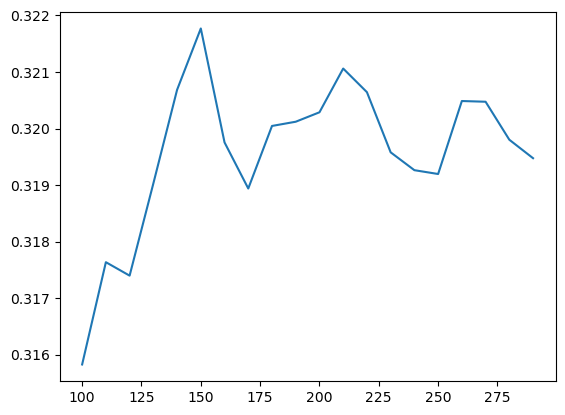

In [77]:
plt.plot(resultsRF['param_n_estimators'],resultsRF['mean_test_score'], linestyle='solid')

In [82]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(10,111,20)}
gsearch2RF = GridSearchCV(estimator = RandomForestRegressor(n_estimators= 210,min_samples_leaf=10,max_features='sqrt',random_state=10), param_grid = param_test2, scoring='r2',n_jobs=-1, cv=5,verbose=3)
gsearch2RF.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 2/5] END .max_depth=5, min_samples_split=10;, score=0.291 total time=   7.6s
[CV 4/5] END .max_depth=5, min_samples_split=10;, score=0.465 total time=   7.7s
[CV 3/5] END .max_depth=5, min_samples_split=10;, score=0.474 total time=   7.7s
[CV 1/5] END .max_depth=5, min_samples_split=10;, score=0.290 total time=   8.0s
[CV 5/5] END .max_depth=5, min_samples_split=10;, score=0.295 total time=  10.6s
[CV 1/5] END .max_depth=5, min_samples_split=30;, score=0.275 total time=  10.8s
[CV 2/5] END .max_depth=5, min_samples_split=30;, score=0.280 total time=  10.8s
[CV 3/5] END .max_depth=5, min_samples_split=30;, score=0.459 total time=  10.7s
[CV 4/5] END .max_depth=5, min_samples_split=30;, score=0.461 total time=  10.8s
[CV 5/5] END .max_depth=5, min_samples_split=30;, score=0.280 total time=  10.8s
[CV 1/5] END .max_depth=5, min_samples_split=50;, score=0.249 total time=  10.9s
[CV 2/5] END .max_depth=5, min_samples_split=50

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_features='sqrt',
                                             min_samples_leaf=10,
                                             n_estimators=210,
                                             random_state=10),
             n_jobs=-1,
             param_grid={'max_depth': range(5, 16, 2),
                         'min_samples_split': range(10, 111, 20)},
             scoring='r2', verbose=3)

In [87]:
resultsRF = pd.DataFrame(gsearch2RF.cv_results_)
resultsRFSorted = resultsRF.sort_values(by='rank_test_score')
resultsRFSorted.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
47,14.144180,0.276192,0.183110,0.011903,13,9,"{'max_depth': 13, 'min_samples_split': 9}",0.293633,0.293883,0.565091,0.493014,0.344907,0.398105,0.110904,1
41,16.096009,0.626960,0.243197,0.028302,13,3,"{'max_depth': 13, 'min_samples_split': 3}",0.293633,0.293883,0.565091,0.493014,0.344907,0.398105,0.110904,1
42,15.980084,0.768102,0.205515,0.021931,13,4,"{'max_depth': 13, 'min_samples_split': 4}",0.293633,0.293883,0.565091,0.493014,0.344907,0.398105,0.110904,1
43,15.129546,0.144328,0.191852,0.020668,13,5,"{'max_depth': 13, 'min_samples_split': 5}",0.293633,0.293883,0.565091,0.493014,0.344907,0.398105,0.110904,1
44,13.731835,0.106435,0.185193,0.017291,13,6,"{'max_depth': 13, 'min_samples_split': 6}",0.293633,0.293883,0.565091,0.493014,0.344907,0.398105,0.110904,1


In [108]:
param_test2 = {'max_depth':[13], 'min_samples_split':range(19,21,1)}
gsearch2RF = GridSearchCV(estimator = RandomForestRegressor(n_estimators= 210,min_samples_leaf=10,max_features='sqrt',random_state=10), param_grid = param_test2, scoring='r2',n_jobs=-1, cv=5,verbose=3)
gsearch2RF.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END max_depth=13, min_samples_split=19;, score=0.294 total time=  25.9s
[CV 2/5] END max_depth=13, min_samples_split=19;, score=0.294 total time=  25.9s
[CV 4/5] END max_depth=13, min_samples_split=19;, score=0.493 total time=  25.9s
[CV 3/5] END max_depth=13, min_samples_split=19;, score=0.565 total time=  26.0s
[CV 5/5] END max_depth=13, min_samples_split=19;, score=0.345 total time=  17.5s
[CV 1/5] END max_depth=13, min_samples_split=20;, score=0.294 total time=  17.6s
[CV 2/5] END max_depth=13, min_samples_split=20;, score=0.294 total time=  17.6s
[CV 3/5] END max_depth=13, min_samples_split=20;, score=0.565 total time=  17.5s
[CV 4/5] END max_depth=13, min_samples_split=20;, score=0.493 total time=  10.8s
[CV 5/5] END max_depth=13, min_samples_split=20;, score=0.345 total time=  10.9s


GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_features='sqrt',
                                             min_samples_leaf=10,
                                             n_estimators=210,
                                             random_state=10),
             n_jobs=-1,
             param_grid={'max_depth': [13], 'min_samples_split': range(19, 21)},
             scoring='r2', verbose=3)

In [109]:
resultsRF = pd.DataFrame(gsearch2RF.cv_results_)
resultsRFSorted = resultsRF.sort_values(by='rank_test_score')
resultsRFSorted.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,24.039420,3.345714,0.212339,0.011729,13,19,"{'max_depth': 13, 'min_samples_split': 19}",0.293633,0.293883,0.565091,0.493014,0.344907,0.398105,0.110904,1
1,14.706774,3.250902,0.177026,0.037116,13,20,"{'max_depth': 13, 'min_samples_split': 20}",0.293633,0.293883,0.565091,0.493014,0.344907,0.398105,0.110904,1


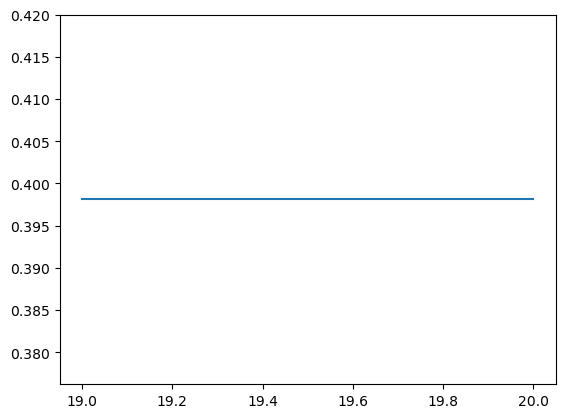

In [110]:
resultsRFPlot = resultsRF[resultsRF["param_max_depth"]==13]
plt.plot(resultsRFPlot['param_min_samples_split'],resultsRFPlot['mean_test_score'], linestyle='solid')

In [133]:
param_test3 = {'max_depth':range(20,50,2)}
gsearch3RF = GridSearchCV(estimator = RandomForestRegressor(n_estimators= 210,max_depth=32,min_samples_leaf=1, min_samples_split=2,max_features='sqrt',random_state=10), param_grid = param_test3, scoring='r2',n_jobs=-1, cv=5,verbose=3)
gsearch3RF.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END ......................max_depth=20;, score=0.872 total time=  28.5s
[CV 4/5] END ......................max_depth=20;, score=0.663 total time=  28.5s
[CV 2/5] END ......................max_depth=20;, score=0.869 total time=  28.6s
[CV 3/5] END ......................max_depth=20;, score=0.881 total time=  28.6s
[CV 5/5] END ......................max_depth=20;, score=0.837 total time=  23.9s
[CV 1/5] END ......................max_depth=22;, score=0.875 total time=  24.9s
[CV 2/5] END ......................max_depth=22;, score=0.871 total time=  25.0s
[CV 3/5] END ......................max_depth=22;, score=0.887 total time=  25.0s
[CV 4/5] END ......................max_depth=22;, score=0.670 total time=  28.5s
[CV 5/5] END ......................max_depth=22;, score=0.836 total time=  28.3s
[CV 2/5] END ......................max_depth=24;, score=0.873 total time=  29.1s
[CV 1/5] END ......................max_depth=24;

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_depth=30, max_features='sqrt',
                                             n_estimators=210,
                                             random_state=10),
             n_jobs=-1, param_grid={'max_depth': range(20, 50, 2)},
             scoring='r2', verbose=3)

In [134]:
resultsRF = pd.DataFrame(gsearch3RF.cv_results_)
resultsRFSorted = resultsRF.sort_values(by='rank_test_score')
resultsRFSorted.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,21.157048,0.070203,0.360616,0.021077,32,{'max_depth': 32},0.879133,0.870660,0.885778,0.679401,0.828175,0.828629,0.077269,1
2,28.533004,0.202482,0.721373,0.220370,24,{'max_depth': 24},0.879877,0.872903,0.879936,0.676838,0.831755,0.828262,0.077805,2
7,21.565071,0.141718,0.367033,0.019498,34,{'max_depth': 34},0.876431,0.875868,0.884315,0.683156,0.821415,0.828237,0.075936,3
4,21.066482,0.490142,0.410970,0.081898,28,{'max_depth': 28},0.876123,0.869006,0.888245,0.664942,0.842494,0.828162,0.082976,4
1,25.879603,1.620598,0.438015,0.082958,22,{'max_depth': 22},0.874527,0.870646,0.887064,0.669841,0.835673,0.827550,0.080677,5
9,21.729096,0.197837,0.427850,0.044063,38,{'max_depth': 38},0.873257,0.868631,0.886325,0.670535,0.836777,0.827105,0.079961,6
5,22.109150,0.545092,0.392500,0.046070,30,{'max_depth': 30},0.873872,0.867652,0.889380,0.670280,0.831048,0.826446,0.080395,7
3,23.506050,3.298103,0.402920,0.058783,26,{'max_depth': 26},0.880492,0.871587,0.883050,0.668317,0.825862,0.825862,0.081445,8
8,21.604104,0.125933,0.380933,0.046238,36,{'max_depth': 36},0.873798,0.867560,0.886039,0.668747,0.833123,0.825853,0.080493,9
0,26.863978,1.642217,0.740560,0.215692,20,{'max_depth': 20},0.872316,0.869090,0.880801,0.663485,0.837113,0.824561,0.081889,10


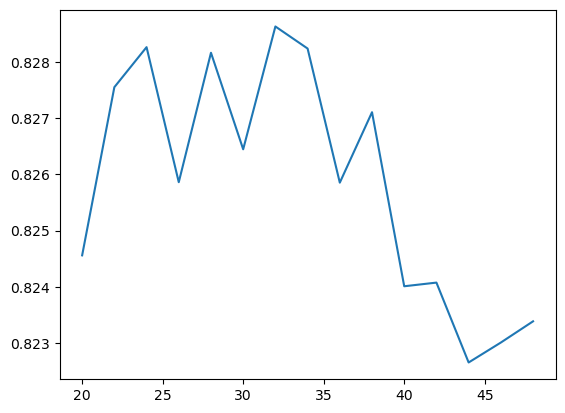

In [135]:
plt.plot(resultsRF['param_max_depth'],resultsRF['mean_test_score'], linestyle='solid')

In [136]:
best = {'n_estimators': 210, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 32, 'criterion': 'poisson', 'bootstrap': False}
rf = RandomForestRegressor(**best)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
r2_score(y_test, y_pred)

0.8111898654985612

Retirando features sem importancia

Text(0.5, 0, 'Random Forest Feature Importance')

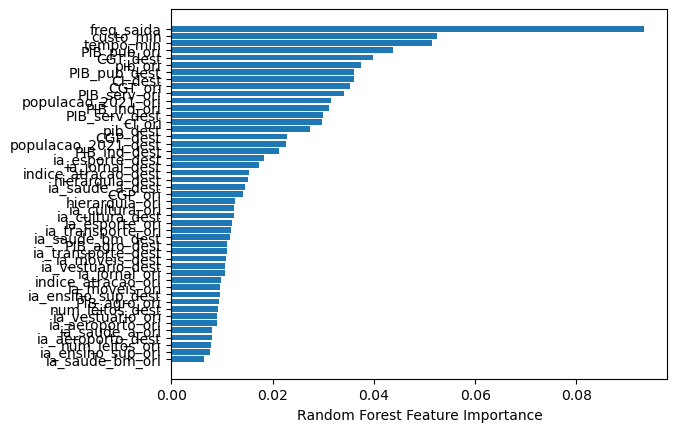

In [137]:
from matplotlib import pyplot as plt
sorted_idx = rf.feature_importances_.argsort()
plt.barh(df_features.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [202]:
res = rf.predict(X_test)
df_res = pd.DataFrame()
df_res['prediction'] = res
df_res['label'] = y_test
rf.feature_importances_

array([0.05238414, 0.05149648, 0.09333111, 0.02727832, 0.01105555,
       0.02125076, 0.02988416, 0.0361176 , 0.01510246, 0.03975548,
       0.03605677, 0.02289349, 0.01540947, 0.0106163 , 0.01067569,
       0.01147067, 0.01452442, 0.00950544, 0.01230626, 0.01826577,
       0.00800027, 0.01733598, 0.01087359, 0.00921597, 0.03745713,
       0.00943552, 0.03107475, 0.03403569, 0.04380364, 0.01253211,
       0.03525559, 0.02971719, 0.01407227, 0.00968762, 0.00904758,
       0.00950864, 0.00633314, 0.00801522, 0.00760812, 0.01233993,
       0.01188999, 0.00901907, 0.0105902 , 0.01167534, 0.00789331,
       0.02263585, 0.03156596])

In [203]:
res = pd.DataFrame()
res["real"] = y_test
res["pred"] = y_pred
res.head(50)

,real,pred
0,60.0,54.777382
1,11.0,-94.066583
2,33.0,20.102441
3,129.0,142.406818
4,459.0,532.728154
5,5.0,-134.254676
6,523.0,337.738697
7,75.0,-106.813562
8,62.0,66.523934
9,671.0,62.881334


Text(0.5, 0, 'Random Forest Feature Importance')

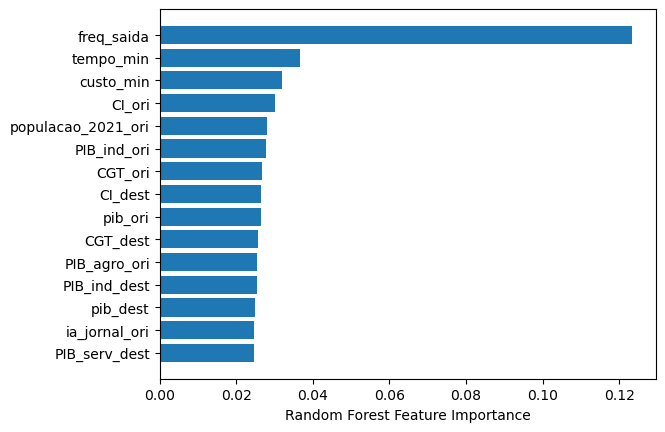

In [457]:
from matplotlib import pyplot as plt
sorted_idx = rf.feature_importances_.argsort()
plt.barh(df_features.columns[sorted_idx][-15:], rf.feature_importances_[sorted_idx][-15:])
plt.xlabel("Random Forest Feature Importance")

### ExtraTrees Regressor

In [443]:
ETR = ExtraTreesRegressor()
parameters = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

r_search_ET = RandomizedSearchCV(estimator=ETR, param_distributions = parameters, n_iter = 50,cv = 3, n_jobs=-1,verbose=3)
r_search_ET.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 2/3] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=1400;, score=0.433 total time=  23.1s
[CV 1/3] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=1400;, score=0.459 total time=  23.5s
[CV 3/3] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=1400;, score=0.465 total time=  24.0s
[CV 1/3] END bootstrap=True, max_depth=60, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=1600;, score=0.706 total time= 3.5min
[CV 1/3] END bootstrap=False, max_depth=100, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=1600;, score=0.562 total time= 5.3min
[CV 2/3] END bootstrap=False, max_depth=100, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=1600;, score=0.609 total time= 5.3min
[CV 3/

RandomizedSearchCV(cv=3, estimator=ExtraTreesRegressor(), n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 400, 600,
                                                         800, 1000, 1200, 1400,
                                                         1600, 1800, 2000]},
                   verbose=3)

In [444]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",r_search_ET.best_estimator_)
print("\n The best score across ALL searched params:\n",r_search_ET.best_score_)
print("\n The best parameters across ALL searched params:\n",r_search_ET.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 ExtraTreesRegressor(max_depth=30, max_features='sqrt', n_estimators=200)

 The best score across ALL searched params:
 0.9185794377341171

 The best parameters across ALL searched params:
 {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}


In [445]:
r_search_ET.score(X_test, y_test)

0.7795705415264084

### DesicionTree Regressor

In [446]:
DTR = DecisionTreeRegressor()
parameters = {
    'criterion': ["squared_error", "friedman_mse", "absolute_error", "poisson"],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]}

r_search_DT = RandomizedSearchCV(estimator=DTR, param_distributions = parameters, n_iter = 50,cv = 3, n_jobs=-1,verbose=3)
r_search_DT.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3] END criterion=friedman_mse, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5;, score=0.749 total time=   0.1s
[CV 2/3] END criterion=friedman_mse, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5;, score=0.917 total time=   0.1s
[CV 3/3] END criterion=friedman_mse, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5;, score=0.607 total time=   0.1s
[CV 1/3] END criterion=absolute_error, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=5;, score=0.299 total time=   8.3s
[CV 2/3] END criterion=absolute_error, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=5;, score=0.406 total time=   9.1s
[CV 3/3] END criterion=absolute_error, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=5;, score=0.295 total time=   9.7s
[CV 1/3] END criterion=poisson, max_depth=90, max_features=None, min_sa

RandomizedSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'friedman_mse',
                                                      'absolute_error',
                                                      'poisson'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   verbose=3)

In [447]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",r_search_DT.best_estimator_)
print("\n The best score across ALL searched params:\n",r_search_DT.best_score_)
print("\n The best parameters across ALL searched params:\n",r_search_DT.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 DecisionTreeRegressor(max_depth=30)

 The best score across ALL searched params:
 0.8884424198262559

 The best parameters across ALL searched params:
 {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 30, 'criterion': 'squared_error'}


In [448]:
r_search_DT.score(X_test, y_test)

0.960900664532559

# Gerando fluxo a partir de regressor

In [13]:
# Melhor modelo
from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor(n_estimators = 1200, min_samples_split = 120, max_depth = 5, learning_rate=0.3,subsample = .85,max_features=15,random_state=10)
GBR.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [ ]:
#Dados a prever 
df_regic_merge